## TODO

1. Pick a dataset -- Used the flower recognition dataset in Kaggle.com/datasets
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Download the dataset
Using the "opendatasets" and download the flower datasets from Kaggle.

The link to the datasets is as below:

https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od


In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged'

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yusuffomoloja
Your Kaggle Key: ··········


100%|██████████| 15.6M/15.6M [00:00<00:00, 97.3MB/s]

In [ ]:
data_dir = './nike-adidas-and-converse-imaged/train'
data_dir_test = './nike-adidas-and-converse-imaged/test'
data_dr = './nike-adidas-and-converse-imaged'

In [ ]:
import os


In [ ]:
os.listdir(data_dir)

['converse', 'nike', 'adidas']

In [ ]:
os.listdir(data_dir_test)

['converse', 'nike', 'adidas']

#### Importing data into Pytorch by using the Torchvision library 

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

711

In [ ]:
dataset.classes

['adidas', 'converse', 'nike']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + "/" + cls)))

converse : 237
nike : 237
adidas : 237


In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=240x240 at 0x7FF9AEE3EDD0>, 0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

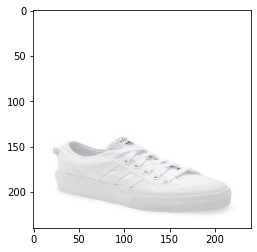

In [ ]:
img,label = dataset[0]
plt.imshow(img)

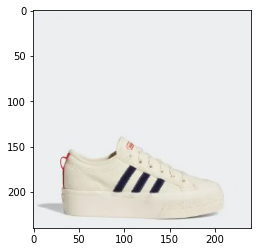

In [ ]:
img,label = dataset[100]
plt.imshow(img)

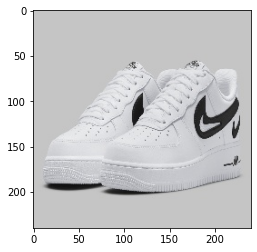

In [ ]:
img,label = dataset[700]
plt.imshow(img)

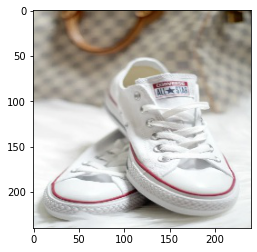

In [ ]:
img,label = dataset[300]
plt.imshow(img)

### Transforming data
In deep learning we need all the data to be in the same size.

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(224),tt.RandomCrop(224),tt.ToTensor()]))

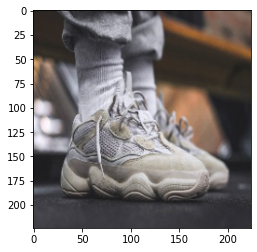

In [ ]:
img,label = dataset[200]
plt.imshow(img.permute((1,2,0)))

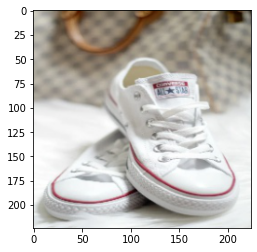

In [ ]:
img,label = dataset[300]
plt.imshow(img.permute((1,2,0)))

## Splitting Data

using the random_split function to transform to training and Validation data

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset)- val_size

train_size,val_size

(640, 71)

In [ ]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

(640, 71)

## Creating Data Loaders 

This is for training and validation to load the data in batches

In [ ]:
from torch.utils.data import DataLoader

batch_size = 15

train_d1 = DataLoader(train_ds,
                      batch_size,shuffle = True, 
                      num_workers = 4, 
                      pin_memory=True )

val_d1 = DataLoader(valid_ds,
                    batch_size*2, 
                    num_workers=4,
                    pin_memory = True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(d1):
  for images, labels in d1:
    fig, ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

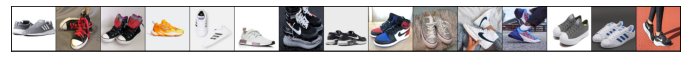

In [ ]:
show_batch(train_d1)

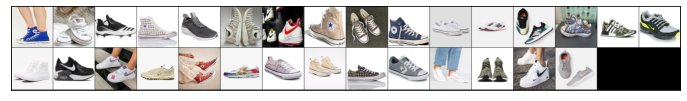

In [ ]:
show_batch(val_d1)

## GPU Utility functions and classes

In [ ]:
def get_default_device():
  """ Pick GPU if available, else CPU """
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  """ move tensor(s) to chosen device """
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data to a device"""
  def __init__(self,d1,device):
    self.d1 =d1
    self.device=device

  def __iter__(self):
    """ Yield a batch of data after moving it to device """
    for b in self.d1:
      yield to_device(b,self.device)

  def __len__(self):
    """ number of batches """
    return len(self.d1)


      

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
img,label = dataset[0]
img.device

device(type='cpu')

move tensor(s) to chosen device 

In [ ]:
img_gpu = to_device(img,device)
img_gpu.device

device(type='cuda', index=0)

Wrapping a dataloader to move data to a choosen device

In [ ]:
train_d1 = DeviceDataLoader(train_d1,device)
val_d1 = DeviceDataLoader(val_d1,device)

Model and Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll use nn.Sequential to chain the layers and activations functions into a single network architecture.

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(200704, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 30))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=30, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Moving our model to the GPU

In [ ]:
model = to_device(model, device)
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=30, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

## Training the **Model**

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val_d1)

{'val_loss': 3.37870192527771, 'val_acc': 0.0}

Using below hyperparameter to train the model

In [ ]:
import torch

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_d1, val_d1, opt_func)

Epoch [0], train_loss: 1.4952, val_loss: 1.1108, val_acc: 0.2970
Epoch [1], train_loss: 1.1517, val_loss: 1.1348, val_acc: 0.2970
Epoch [2], train_loss: 1.1305, val_loss: 1.1176, val_acc: 0.3707
Epoch [3], train_loss: 1.1155, val_loss: 1.1264, val_acc: 0.2970
Epoch [4], train_loss: 1.1249, val_loss: 1.1017, val_acc: 0.3707
Epoch [5], train_loss: 1.1227, val_loss: 1.1247, val_acc: 0.3707
Epoch [6], train_loss: 1.1091, val_loss: 1.1414, val_acc: 0.2667
Epoch [7], train_loss: 1.0983, val_loss: 1.1207, val_acc: 0.3515
Epoch [8], train_loss: 1.0829, val_loss: 1.1370, val_acc: 0.3818
Epoch [9], train_loss: 1.0909, val_loss: 1.1977, val_acc: 0.4374


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

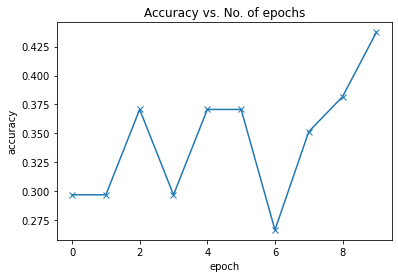

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

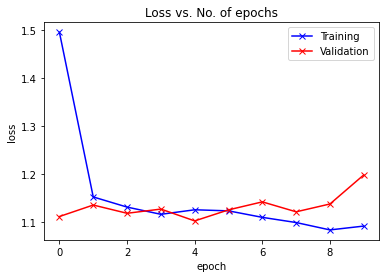

In [ ]:
plot_losses(history)

### Testing the model


In [ ]:
from torchvision.transforms import ToTensor



## Transforming Test Data

In [ ]:
import torchvision.transforms as tt

test_dataset = ImageFolder(data_dir_test,tt.Compose([tt.Resize(224),tt.RandomCrop(224),tt.ToTensor()]))

In [ ]:
#test_dataset = ImageFolder(data_dr + '/test', transform= ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: adidas , Predicted: nike


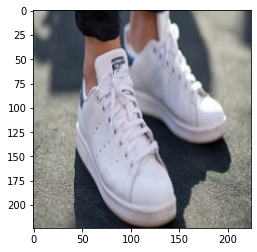

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
len(data_dir_test)

38

Label: converse , Predicted: nike


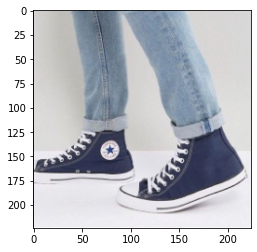

In [ ]:
img, label = test_dataset[38]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: nike


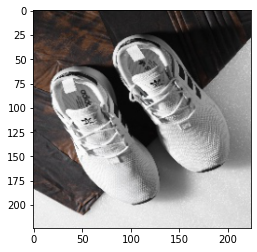

In [ ]:
img, label = test_dataset[20]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: adidas


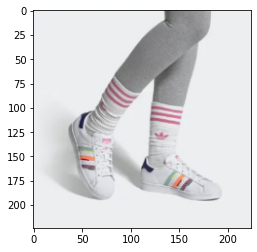

In [ ]:
img, label = test_dataset[22]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: adidas


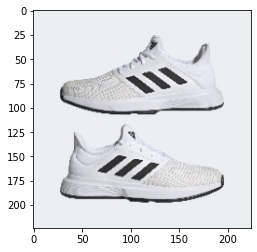

In [ ]:
img, label = test_dataset[33]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: nike


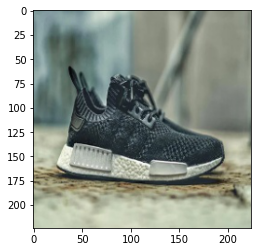

In [ ]:
img, label = test_dataset[35]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: adidas


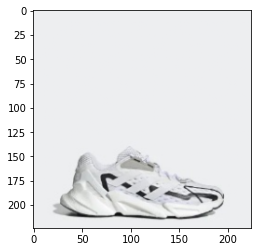

In [ ]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: adidas


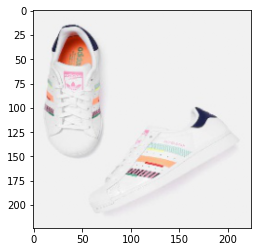

In [ ]:
img, label = test_dataset[15]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: converse


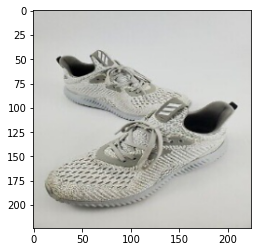

In [ ]:
img, label = test_dataset[29]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: adidas


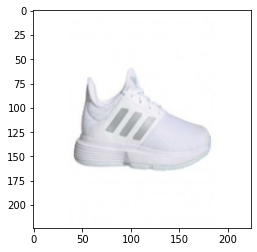

In [ ]:
img, label = test_dataset[32]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: adidas , Predicted: converse


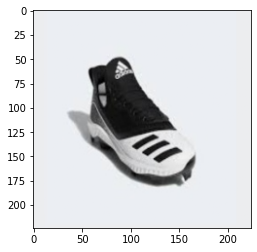

In [ ]:
img, label = test_dataset[37]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.1727180480957031, 'val_acc': 0.4166666865348816}

### Saving and Loading Model

Since we have trained our model for a long time and achieved a reasonable accuracy, it would be a good idea to save the weights of the models to disk so that we can reuse the model later and avoid retraining from the scratch. 

In [ ]:
torch.save(model.state_dict(),'adidas-nike-converse.pth')

the .state_dict method returns an orderderd dict containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights we can redefine the model with the same structure and .load_state_dict method

In [ ]:
model2 = to_device(Cifar10CnnModel(),device)

In [ ]:
model2.load_state_dict(torch.load('adidas-nike-converse.pth'))

<All keys matched successfully>